In [4]:
import dynamo as dyn
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn import preprocessing

/home/dap182/anaconda3/envs/kb/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [9]:
def plot_X(X, dim1=0, dim2=1, create_figure=False, figsize=(6, 6), **kwargs):
    if create_figure:
        plt.figure(figsize=figsize)
    plt.scatter(X[:, dim1], X[:, dim2], **kwargs)
    
def plot_V(X, V, dim1=0, dim2=1, create_figure=False, figsize=(6, 6), **kwargs):
    if create_figure:
        plt.figure(figsize=figsize)
    plt.quiver(X[:, dim1], X[:, dim2], V[:, dim1], V[:, dim2])
    
def color_set(data,gene):
    gene_idx=np.where(data.var_names==gene)[0][0]
    c=np.squeeze(np.asarray(data.X[:,gene_idx].todense()))
    return c

def color_treatment(adata):
    le=preprocessing.LabelEncoder()
    treatment=adata.obsm['treatment']
    uniq_labels=np.unique(treatment)
    labels=le.fit(uniq_labels)
    classes=le.classes_
    print(le.classes_)
    encoded=le.transform(treatment)
    print(le.get_params())
    return encoded,le

def simulation(tr,num_trajectories,init_probs,final_states):
    #using list because trajectories can be different sizes
    traj_list=[]
    for traj in range(num_trajectories):
        #uses init probabilities to find the initial state
        boolean=np.cumsum(p0)<=np.random.uniform()
        state=np.where(boolean==False)[0][0]
        #appends the first state to the traj list
        traj_list.append(np.array([state]))
        while state not in final_states:
            boolean_list=np.cumsum(tr.P[:,state].data)<=np.random.uniform()
            state=int(np.argwhere(boolean_list==False)[0][0])
            #state=int(tr.Idx[state][np.where(boolean_list==False)[0][0]])
            traj_list[traj]=np.append(traj_list[traj],state)

    return traj_list
    

In [10]:
kmc.Idx[3308][3324]

IndexError: index 3324 is out of bounds for axis 0 with size 336

In [11]:
matrix=simulation(kmc,1,p0,final_states)

In [6]:
P=np.loadtxt('all_cells/a549_tgfb1_emt_genes_P.npy')
Idx=np.load('all_cells/a549_tgfb1_emt_genes_idx.npy',allow_pickle=True)
adata=dyn.read_h5ad('all_cells/a549_tgfb1_emt_genes_processed.h5ad')

In [7]:
kmc=dyn.tl.KernelMarkovChain(P=P,Idx=Idx)

X = adata.layers['M_s'][:, adata.var['use_for_velocity']]
V = adata.layers['velocity_S'][:, adata.var['use_for_velocity']]
#X_emb = adata.obsm['X_pca']
X_emb = adata.obsm['X_umap']

Uc = kmc.compute_density_corrected_drift(X_emb, normalize_vector=True)

sd = kmc.compute_stationary_distribution()

U_grid, X_grid = dyn.tl.smoothen_drift_on_grid(X_emb[:, :2], Uc[:, :2], 30, k=50, smoothness=0.5)

calculating density corrected drift: 100%|██████████| 3567/3567 [00:01<00:00, 2678.95it/s]


In [8]:
p0 = np.zeros(kmc.P.shape[0])

st_dist = kmc.compute_stationary_distribution()
final_states=np.where(st_dist>np.percentile(st_dist,99))[0]
p0[np.logical_and(X_emb[:, 0] > -2, X_emb[:, 1] >1)] = 1
p0 = p0 / np.sum(p0)

p_end=np.zeros(kmc.P.shape[0])
p_end[st_dist>np.percentile(st_dist,95)]=1
p_end = p_end / np.sum(p_end)

matrix=simulation(kmc,1,p0,final_states)

1753
[ 123  137  153  177  210  223  229  610  706  811  814 1033 1110 1114
 1122 1123 1128 1176 1188 1196 1202 1209 1215 1221 1229 1246 1249 1251
 1257 1259 1267 1278 1279 1282 1284 1303 1304 1313 1340 1355 1360 1363
 1371 1374 1376 1388 1393 1394 1408 1414 1424 1434 1443 1450 1453 1455
 1472 1473 1475 1476 1480 1482 1486 1488 1489 1495 1497 1500 1504 1505
 1508 1509 1513 1514 1517 1525 1529 1533 1537 1539 1542 1545 1548 1550
 1554 1560 1566 1572 1578 1581 1582 1595 1598 1599 1602 1610 1614 1616
 1619 1622 1623 1626 1627 1634 1635 1636 1639 1640 1643 1646 1650 1652
 1663 1664 1665 1666 1668 1676 1677 1684 1694 1697 1701 1703 1731 1738
 1741 1746 1748 1753 1754 1760 1762 1763 1766 1775 1780 1794 1796 1805
 1806 1818 1820 1830 1846 1848 1851 1861 1869 1877 1884 1887 1892 1896
 1900 1903 1908 1912 1913 1916 1918 1922 1925 1933 1934 1935 1936 1938
 1946 1952 1965 1971 1977 2003 2006 2016 2018 2019 2223 2364 2403 2428
 2447 2450 2454 2466 2555 2625 2653 2659 2665 2672 2692 2727 2766 2776
 

In [30]:
colors,le=color_treatment(adata)

clrs=np.divide(colors,8).astype('str')
treatment=np.divide(colors,8).astype('str')

clrs[clrs=="0.0"]='b'
clrs[clrs=="0.75"]='k'
clrs[clrs=="0.125"]='g'
clrs[clrs=="0.375"]='c'
clrs[clrs=="0.625"]='y'
clrs[clrs=="0.875"]='orange'
clrs[clrs=="0.25"]='r'
clrs[clrs=="0.5"]='m'
                       
                       
treatment[treatment=="0.0"]='0d'
treatment[treatment=="0.75"]='8h'
treatment[treatment=="0.125"]='1d'
treatment[treatment=="0.375"]='3d'
treatment[treatment=="0.625"]='7d'
treatment[treatment=="0.875"]='8h_rm'
treatment[treatment=="0.25"]='1d_rm'
treatment[treatment=="0.5"]='3d_rm'

order=[6,1,7,0,5,4,2,3]

conversion=list(set([(treat,color) for treat,color in zip(treatment,clrs)]))

conversion=[conversion[i] for i in order]

handles=[]
for treatment in conversion:
    color=treatment[1]
    label=treatment[0]
    handles.append(mpatches.Patch(color=color, label=label))


['0d' '1d' '1d_rm' '3d' '3d_rm' '7d' '8h' '8h_rm']
{}


In [31]:
=list(set([(treat,color) for treat,color in zip(treatment,clrs)]))

SyntaxError: invalid syntax (<ipython-input-31-d3d487cc1609>, line 1)

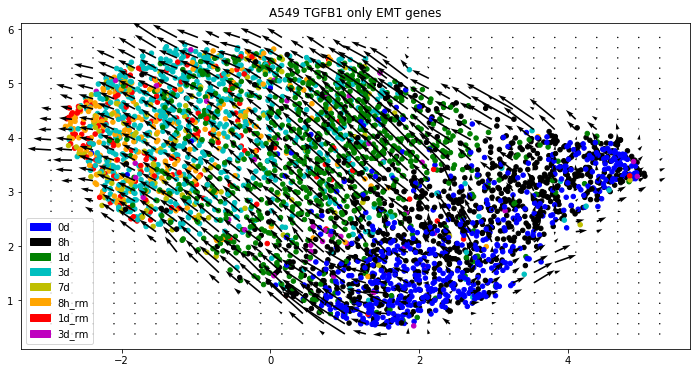

In [32]:
plot_X(X_emb, create_figure=True, figsize=(12, 6),c=clrs,s=20)

plt.legend(handles=handles)

plt.title('A549 TGFB1 only EMT genes')

plot_V(X_grid, U_grid, facecolor='k')

In [18]:
list(set([(color/8,le.inverse_transform([color])[0]) for color in colors]))

[(0.375, '3d'),
 (0.25, '1d_rm'),
 (0.75, '8h'),
 (0.875, '8h_rm'),
 (0.5, '3d_rm'),
 (0.625, '7d'),
 (0.0, '0d'),
 (0.125, '1d')]

In [33]:
emt=['8h','1d','3d','7d']
met=['8h_rm',"1d_rm",'3d_rm']
stable_emt=['0d','8h','1d','3d','7d']

no_treatment_idx=np.squeeze(np.argwhere(adata.obsm['treatment']=='0d'))

treatment=np.isin(adata.obsm['treatment'],emt)
emt_idx=np.squeeze(np.argwhere(treatment==True))

reverse_treatment=np.isin(adata.obsm['treatment'],met)
met_idx=np.squeeze(np.argwhere(reverse_treatment==True))

stable_emt=np.isin(adata.obsm['treatment'],stable_emt)
stable_emt_idx=np.squeeze(np.argwhere(stable_emt==True))

<Figure size 650x500 with 0 Axes>

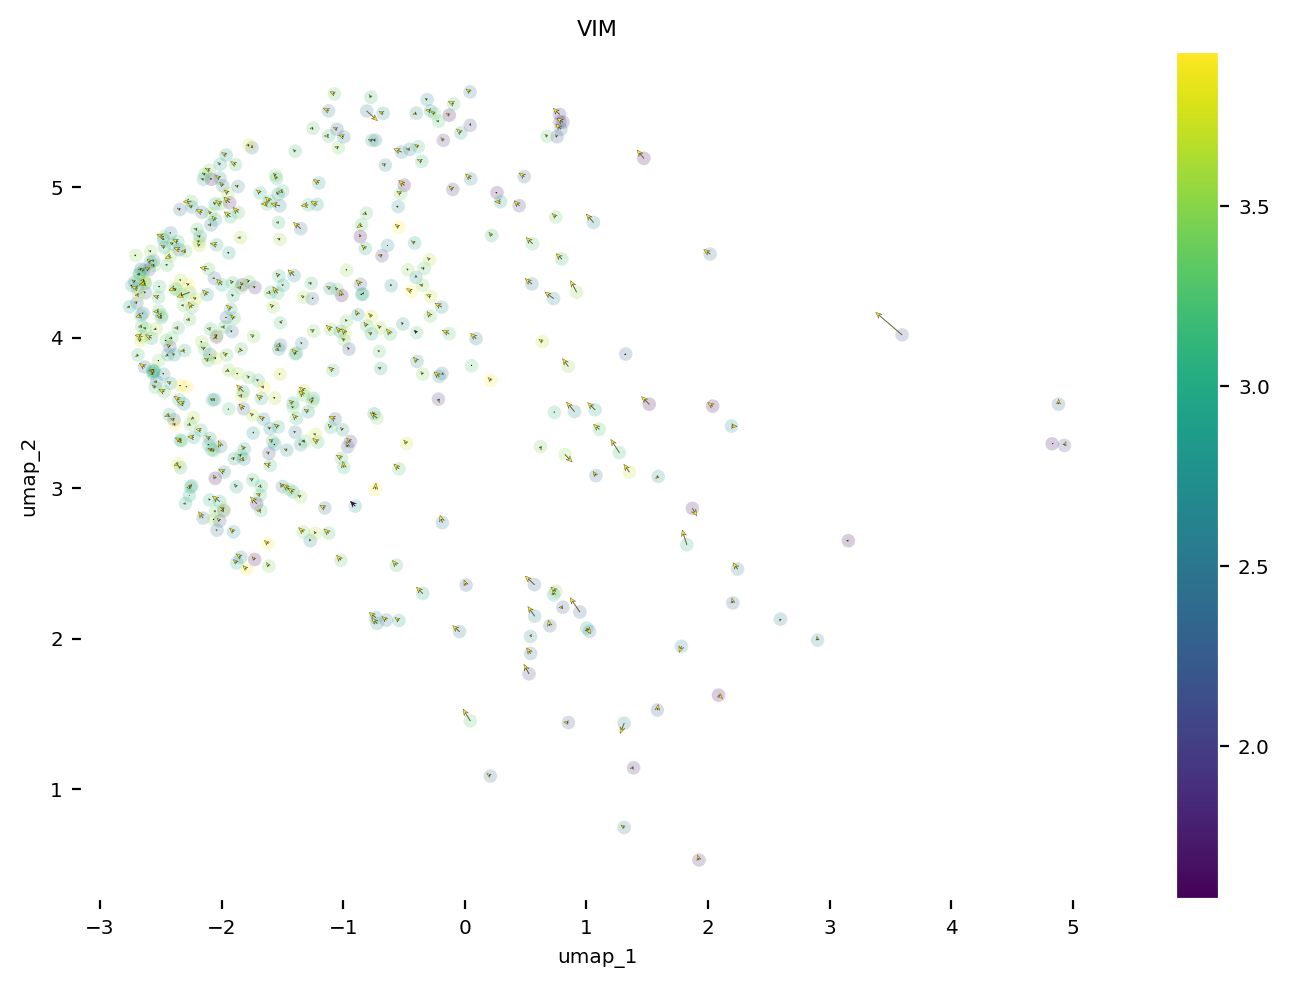

In [38]:
met=adata[met_idx,:]

dyn.pl.cell_wise_velocity(met,color='VIM')

<Figure size 650x500 with 0 Axes>

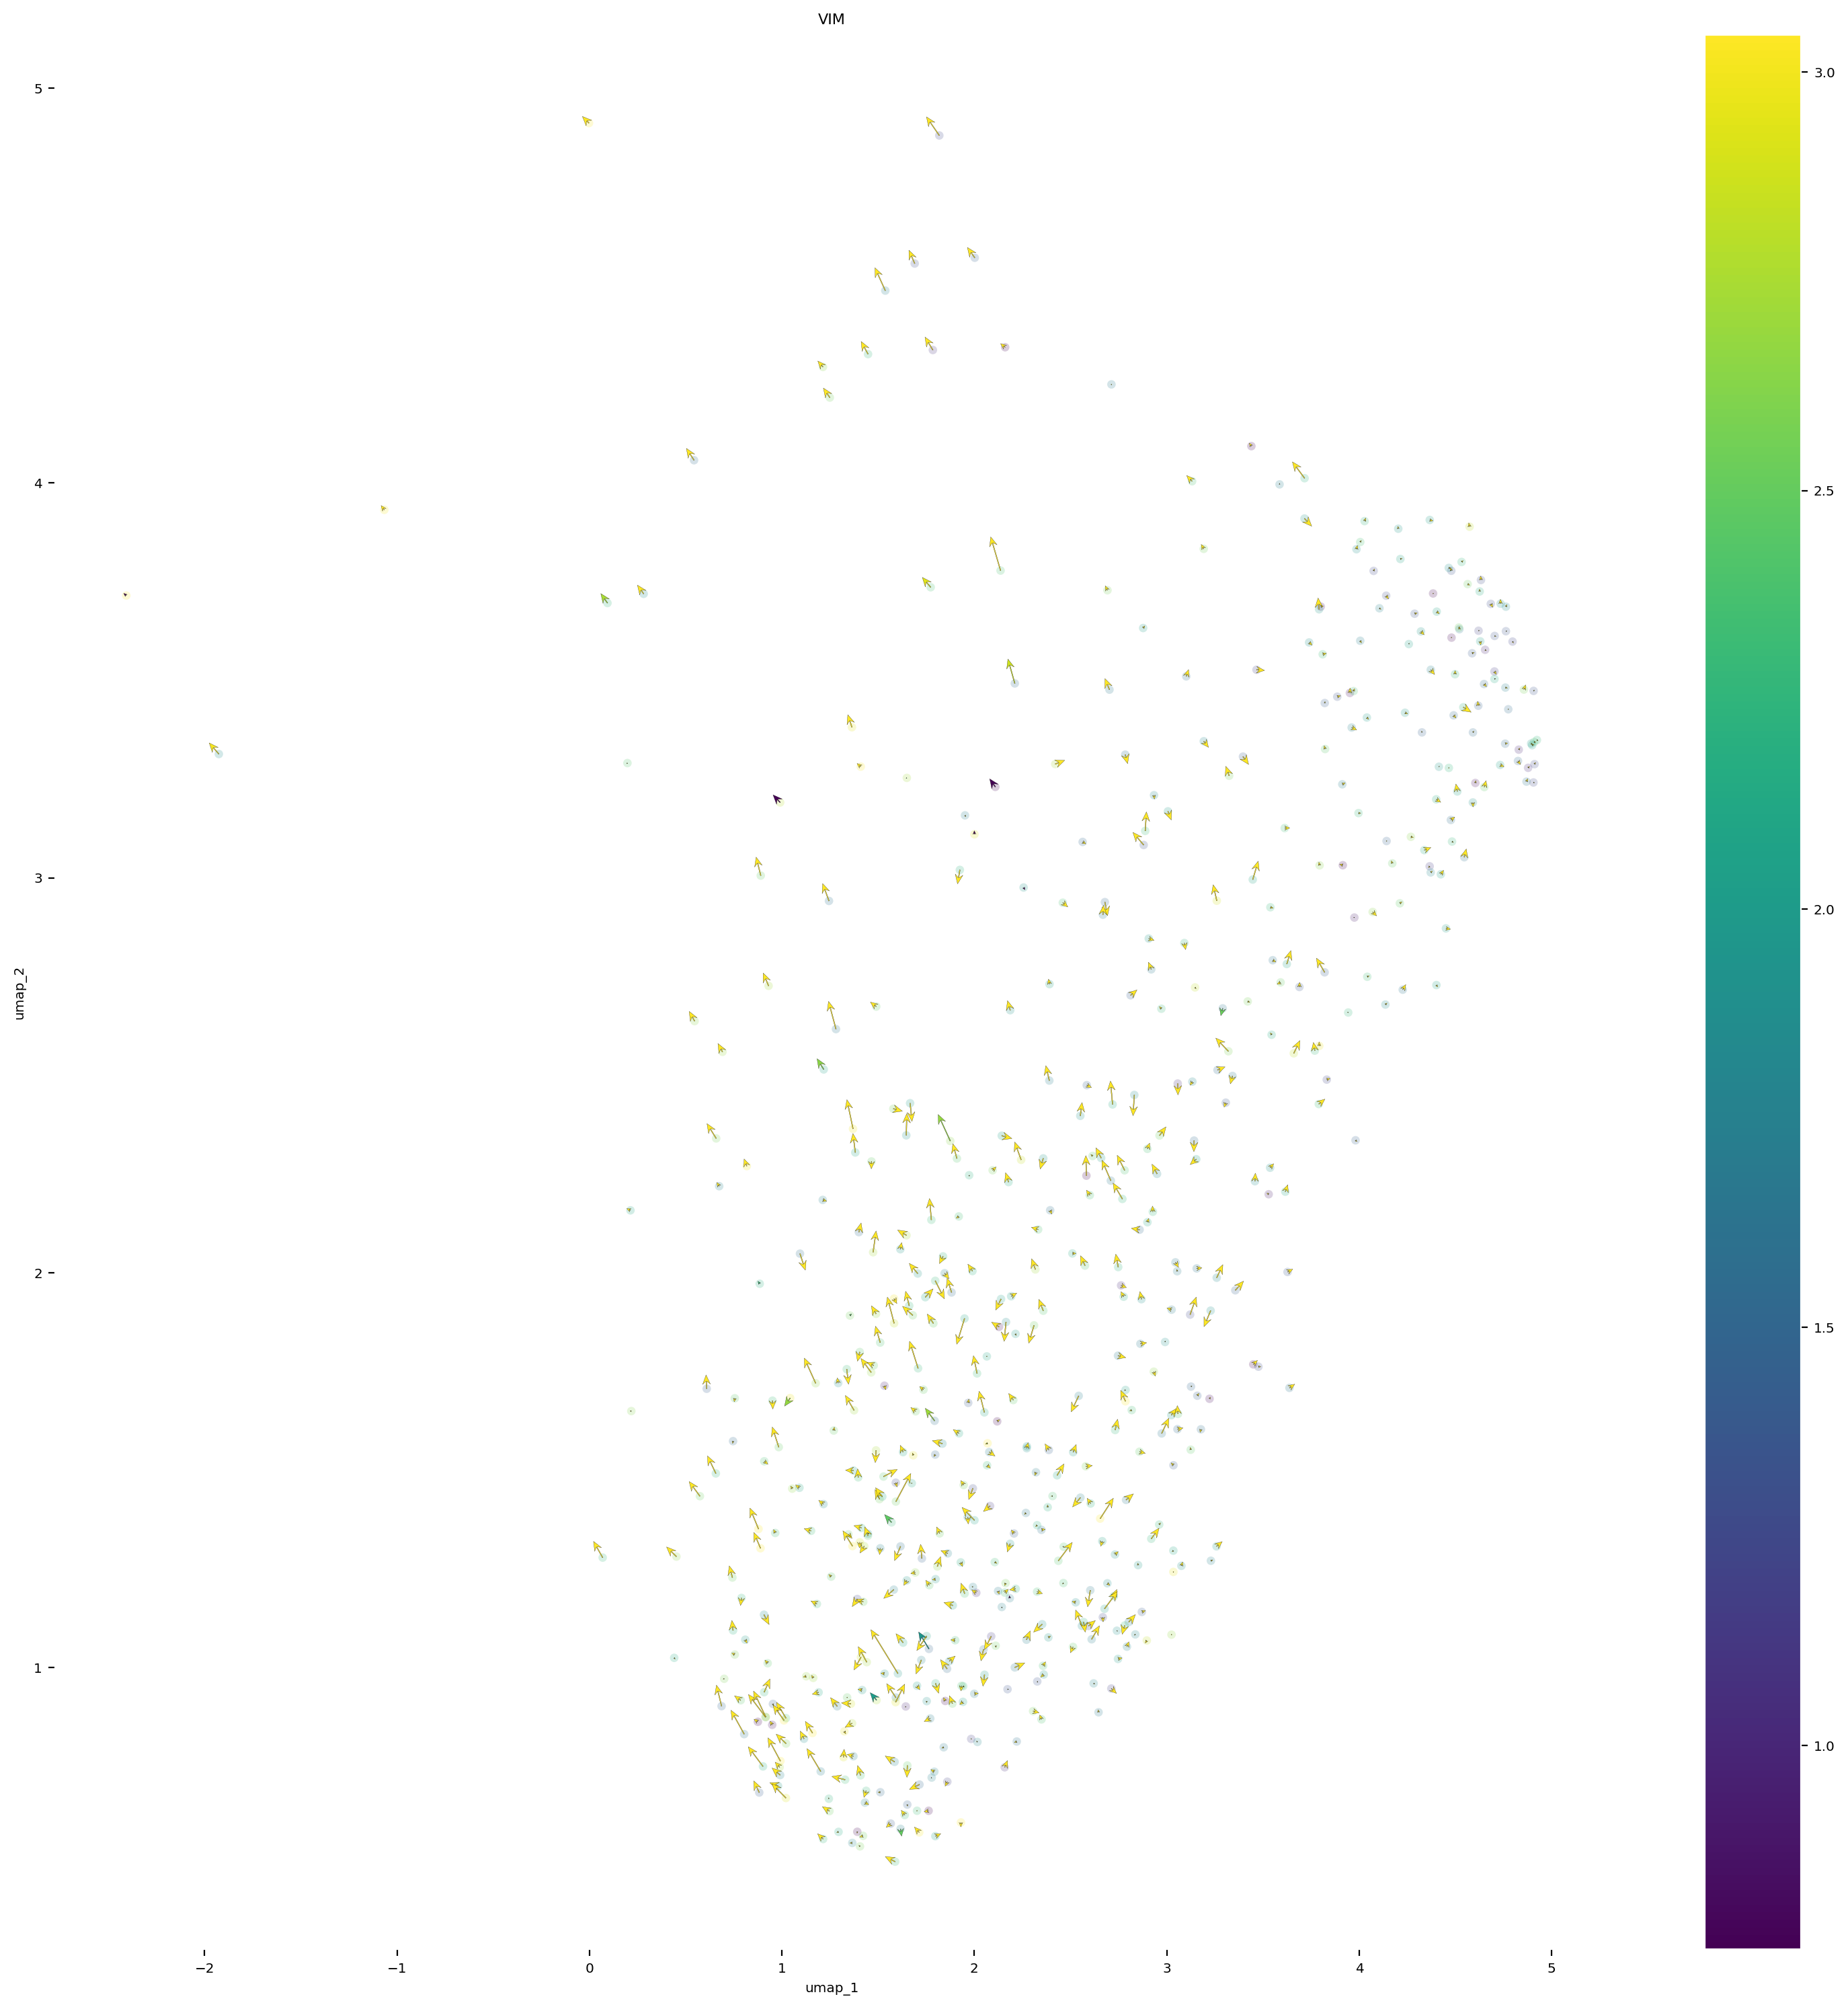

In [42]:
stable=adata[no_treatment_idx,:]

dyn.pl.cell_wise_velocity(stable,color='VIM',figsize=(15,15))

In [19]:

colors,le=color_treatment(adata)

conversion=set([(color/8,le.inverse_transform([color])[0]) for color in colors])

handles=[]
for treatment in conversion:
    color=str(treatment[0])
    print(color)
    label=treatment[1]
    handles.append(mpatches.Patch(color=color, label=label))

['0d' '1d' '1d_rm' '3d' '3d_rm' '7d' '8h' '8h_rm']
{}
0.375
0.25
0.75
0.875
0.5
0.625
0.0
0.125


In [ ]:
for i in colors:
    print(i)

In [60]:
le.inverse_transform([0])

array(['0d'], dtype=object)

In [ ]:
[list(color) for color in colors]

In [ ]:
true_colors=colors.astype(int)*8

In [ ]:
le.inverse_transform(list(true_colors[0]))

In [31]:
true_colors

array([3., 3., 3., ..., 0., 0., 0.])

In [139]:
j=np.array([1,2])

j[j==4]=0

In [140]:
j

array([1, 2])